# Clustering

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn import mixture
from scipy.stats import mode
from tqdm import tqdm

### Baseline Model Kaggle Submission

In [16]:
# Reorder the laebl and format output for kaggle submission
def format_submission(df, label_col = "label"):
    df = df.sort_index()
    df = pd.DataFrame(df[label_col])
    label_mapping = {}
    activtyID_list = []
    raw_label = df[label_col].tolist()
    for l in raw_label:
        if len(label_mapping) == 0:
            label_mapping[l] = 1 # Final label starts with 1
            activtyID_list.append(1)
        elif l not in label_mapping:
            label_mapping[l] = max(list(label_mapping.values())) + 1
            activtyID_list.append(label_mapping[l])
        else:
            activtyID_list.append(label_mapping[l])
    df["activityID"] = activtyID_list
    print(df)
    df.drop(label_col, axis=1, inplace=True)
    df.to_csv("../data/submission.csv", index=True, index_label=["Index"])

In [17]:
# Load the PCA-transformed data
pca_df = pd.read_pickle('../data/time_series_experiment.pkl')
pca_df.head(5)

,timestamp,handTemperature,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
54744,0.000000,0.000000,0.401837,0.305836,0.312975,0.365663,0.375128,0.348325,0.395243,0.602510,...,0.393462,0.408262,0.524000,0.606851,0.672272,0.000000,0.417775,0.397926,0.382401,0.000000
440445,0.000010,0.221712,0.407010,0.320915,0.331777,0.363704,0.375426,0.347909,0.414974,0.503768,...,0.392289,0.408283,0.439128,0.547871,0.552465,0.224084,0.417775,0.397926,0.382401,0.054067
238954,0.000013,0.403079,0.411922,0.332959,0.351309,0.362150,0.376479,0.347719,0.433637,0.396614,...,0.389738,0.408373,0.346387,0.485368,0.418185,0.407032,0.417775,0.397926,0.382401,0.105361
22854,0.000015,0.403079,0.411586,0.330196,0.352917,0.363331,0.376686,0.348301,0.433644,0.400297,...,0.388636,0.408238,0.344753,0.486169,0.421614,0.407032,0.417775,0.397926,0.382401,0.105361
366131,0.000020,0.403079,0.411493,0.330628,0.353978,0.366726,0.376706,0.348739,0.433160,0.401241,...,0.390618,0.407909,0.340365,0.485572,0.420735,0.407032,0.417775,0.397926,0.382401,0.105361


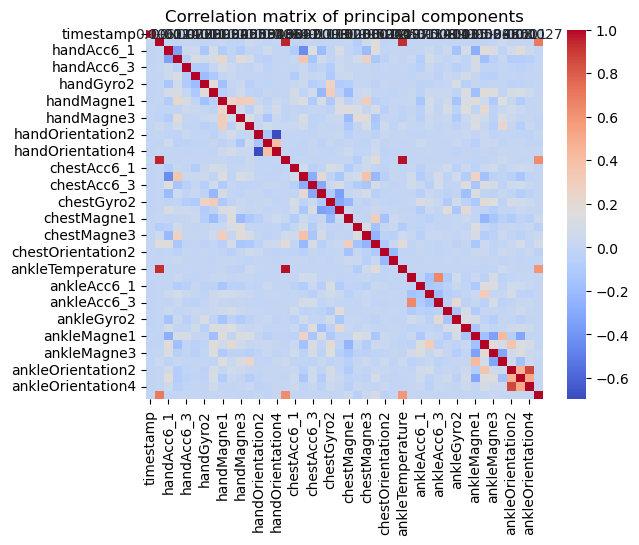

In [18]:
# Plot correlation matrix of principal components
corr_matrix = pca_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of principal components')
plt.show()

### KMeans

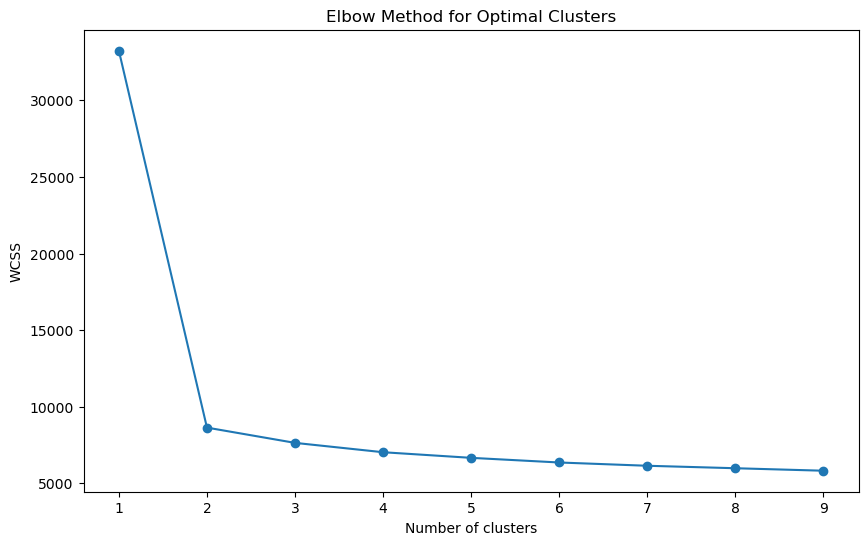

CPU times: user 5min 11s, sys: 19.4 s, total: 5min 30s
Wall time: 57.1 s


In [19]:
%%time

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
%%time

from sklearn.metrics import silhouette_score

# Define the fraction of data to use (e.g., 0.1 for 10%)
sample_fraction = 0.1

# Sample a subset of the data
data_sample = pca_df.sample(frac=sample_fraction, random_state=42)

# Determine the optimal number of clusters using a data subset
best_score = -1
best_k = 0
range_n_clusters = list(range(2, 20))

# Loop through the range of cluster numbers with tqdm for progress bar
for n_clusters in tqdm(range_n_clusters, desc="Evaluating number of clusters"):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(data_sample)
    silhouette_avg = silhouette_score(data_sample, cluster_labels)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = n_clusters

print(f"Optimal number of clusters: {best_k}, with silhouette score: {best_score}")

Evaluating number of clusters:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating number of clusters: 100%|██████████| 18/18 [10:36<00:00, 35.38s/it]

Optimal number of clusters: 2, with silhouette score: 0.693665658854532
CPU times: user 16min 27s, sys: 7min 20s, total: 23min 48s
Wall time: 10min 37s


In [21]:
%%time

from sklearn.metrics import calinski_harabasz_score

best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

data_normalized = pca_df

# Loop through the range of k values with tqdm for progress bar
for k in tqdm(range(2, 20), desc="Evaluating number of clusters"):
    # Fit the KMeans model
    candidate_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=0)
    candidate_kmeans.fit(data_normalized)
    
    # Predict the cluster assignments
    cluster_assignments = candidate_kmeans.predict(data_normalized)
    
    # Calculate the Calinski-Harabasz score
    score = calinski_harabasz_score(data_normalized, cluster_assignments)
    print(f'k = {k} has CH index {score}')
    
    # Check if the current score is the best
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_kmeans
        best_cluster_assignments = cluster_assignments

# Output the best number of clusters
print(f'Best k within 2, 3, ..., 19 according to CH index: {best_k}')

Evaluating number of clusters:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating number of clusters:   6%|▌         | 1/18 [00:02<00:46,  2.74s/it]

k = 2 has CH index 1522179.6843254075


Evaluating number of clusters:  11%|█         | 2/18 [00:06<00:54,  3.40s/it]

k = 3 has CH index 895196.5432533679


Evaluating number of clusters:  17%|█▋        | 3/18 [00:11<01:01,  4.10s/it]

k = 4 has CH index 664040.304823834


Evaluating number of clusters:  22%|██▏       | 4/18 [00:17<01:10,  5.03s/it]

k = 5 has CH index 532776.1268461192


Evaluating number of clusters:  28%|██▊       | 5/18 [00:25<01:16,  5.87s/it]

k = 6 has CH index 451669.67089161


Evaluating number of clusters:  33%|███▎      | 6/18 [00:35<01:28,  7.40s/it]

k = 7 has CH index 392538.09403848014


Evaluating number of clusters:  39%|███▉      | 7/18 [00:48<01:41,  9.20s/it]

k = 8 has CH index 347576.4250974186


Evaluating number of clusters:  44%|████▍     | 8/18 [01:02<01:48, 10.82s/it]

k = 9 has CH index 314469.7405502282


Evaluating number of clusters:  50%|█████     | 9/18 [01:23<02:03, 13.74s/it]

k = 10 has CH index 288126.0298230398


Evaluating number of clusters:  56%|█████▌    | 10/18 [01:41<02:01, 15.13s/it]

k = 11 has CH index 265820.73436492286


Evaluating number of clusters:  61%|██████    | 11/18 [01:54<01:41, 14.53s/it]

k = 12 has CH index 247943.47086350704


Evaluating number of clusters:  67%|██████▋   | 12/18 [02:12<01:34, 15.73s/it]

k = 13 has CH index 231785.73815842043


Evaluating number of clusters:  72%|███████▏  | 13/18 [02:28<01:18, 15.72s/it]

k = 14 has CH index 220811.9565614049


Evaluating number of clusters:  78%|███████▊  | 14/18 [02:50<01:10, 17.70s/it]

k = 15 has CH index 208870.08461994308


Evaluating number of clusters:  83%|████████▎ | 15/18 [03:09<00:53, 17.93s/it]

k = 16 has CH index 198881.14774375455


Evaluating number of clusters:  89%|████████▉ | 16/18 [03:37<00:42, 21.01s/it]

k = 17 has CH index 192357.62180459613


Evaluating number of clusters:  94%|█████████▍| 17/18 [04:00<00:21, 21.51s/it]

k = 18 has CH index 184266.47978359574


Evaluating number of clusters: 100%|██████████| 18/18 [04:20<00:00, 14.48s/it]

k = 19 has CH index 177579.92789514907
Best k within 2, 3, ..., 19 according to CH index: 2
CPU times: user 23min 47s, sys: 1min 11s, total: 24min 58s
Wall time: 4min 20s


In [22]:
# Helper function to get Betweenss (inter-cluster distance)
# def get_betweenss(cluster_model):
#     betweenss = 0
#     overall_mean = np.mean(pca_df, axis=0)
#     for i in range(cluster_model.n_clusters):
#         cluster_points = pca_df[cluster_model.labels_ == i]
#         cluster_mean = np.mean(cluster_points, axis=0)
#         cluster_size = len(cluster_points)
#         betweenss += cluster_size * np.sum((cluster_mean - overall_mean) ** 2)
#     return betweenss


In [23]:
# Calculate cohesion (the lower the better) and separation (the higher the better)
# def get_cohesion_and_separation(cluster_model):
#     betweenss = get_betweenss(cluster_model)
#     withinss = cluster_model.inertia_
#     return [withinss/(betweenss + withinss), betweenss/(betweenss + withinss)]

In [24]:
# Allow model comparison with different K values
# def compare_models(k_list):
#     model_list = []
#     for k in k_list:
#         kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_df)
#         cohesion, separation = get_cohesion_and_separation(kmeans)
#         print(f"K = {k}, Cohesion = {round(cohesion, 3)}, Separation = {round(separation, 3)}")
#         model_list.append(kmeans)
#     return model_list

# compare_models([5, 10, 15, 20, 25, 30])


In [25]:
# Get baseline model and labeled data
kmeans = KMeans(n_clusters=4, random_state=42).fit(pca_df)
kmeans_labeled = pca_df.assign(label=kmeans.labels_)
kmeans_labeled.head(5)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,timestamp,handTemperature,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,...,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id,label
54744,0.000000,0.000000,0.401837,0.305836,0.312975,0.365663,0.375128,0.348325,0.395243,0.602510,...,0.408262,0.524000,0.606851,0.672272,0.000000,0.417775,0.397926,0.382401,0.000000,2
440445,0.000010,0.221712,0.407010,0.320915,0.331777,0.363704,0.375426,0.347909,0.414974,0.503768,...,0.408283,0.439128,0.547871,0.552465,0.224084,0.417775,0.397926,0.382401,0.054067,2
238954,0.000013,0.403079,0.411922,0.332959,0.351309,0.362150,0.376479,0.347719,0.433637,0.396614,...,0.408373,0.346387,0.485368,0.418185,0.407032,0.417775,0.397926,0.382401,0.105361,2
22854,0.000015,0.403079,0.411586,0.330196,0.352917,0.363331,0.376686,0.348301,0.433644,0.400297,...,0.408238,0.344753,0.486169,0.421614,0.407032,0.417775,0.397926,0.382401,0.105361,2
366131,0.000020,0.403079,0.411493,0.330628,0.353978,0.366726,0.376706,0.348739,0.433160,0.401241,...,0.407909,0.340365,0.485572,0.420735,0.407032,0.417775,0.397926,0.382401,0.105361,2


In [31]:
format_submission(kmeans_labeled)

        label  activityID
0           2           1
1           1           2
2           0           3
3           1           2
4           2           1
...       ...         ...
534596      1           2
534597      3           4
534598      3           4
534599      1           2
534600      0           3

[534601 rows x 2 columns]


In [32]:
unique_clusters = kmeans_labeled['label'].unique()
print(f"Unique clusters: {unique_clusters}")

Unique clusters: [2 0 3 1]


### GMM

In [33]:
from sklearn.mixture import GaussianMixture

# # Fit the GMM model
# gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, random_state=42)
# gmm.fit(pca_df)

# # Predict cluster labels
# gmm_labels = gmm.predict(pca_df)

# # Assign labels to the data
# gmm_labeled = pca_df.assign(label=gmm_labels)
# gmm_labeled.head(5)

# # Print the random state of the model
# print(f"The random state of the model is {gmm.random_state}")

In [34]:
# format_submission(gmm_labeled)

### Bagging Kmeans

In [35]:
# n_clusters = 4
# n_bagging_iterations = 15

# # Initialize result array
# all_labels = np.zeros((pca_df.shape[0], n_bagging_iterations))

# for i in range(n_bagging_iterations):
#     # Construct the single kmeans model
#     pca_df_resampled = resample(pca_df, replace=True, n_samples=round(0.5 * pca_df.shape[0]), random_state=i)
#     kmeans = KMeans(n_clusters=n_clusters, random_state=i)
#     kmeans.fit(pca_df_resampled)
#     raw_label = kmeans.predict(pca_df)
#     label_mapping = {}
#     activtyID_list = []
#     # Reorder label to make it consistent across different interations
#     for l in raw_label:
#         if len(label_mapping) == 0:
#             label_mapping[l] = 1 # Final label starts with 1
#             activtyID_list.append(1)
#         elif l not in label_mapping:
#             label_mapping[l] = max(list(label_mapping.values())) + 1
#             activtyID_list.append(label_mapping[l])
#         else:
#             activtyID_list.append(label_mapping[l])
#     all_labels[:, i] = activtyID_list

# # Find the consensus label
# consensus_labels = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=all_labels)

In [36]:
# submission_df = pd.DataFrame(consensus_labels, index=range(len(pca_df)), columns=["activityID"])
# submission_df.to_csv("../data/submission_bagged.csv", index=True, index_label=["Index"])

### Boosting Kmeans

In [37]:
# n_clusters = 4
# n_boosting_iterations = 15
# sample_weights = np.ones(pca_df.shape[0])
# all_labels = np.zeros((pca_df.shape[0], n_boosting_iterations))

# for i in range(n_boosting_iterations):
#     # Construct the single kmeans model
#     kmeans = KMeans(n_clusters=n_clusters, random_state=i)
#     kmeans.fit(pca_df, sample_weight=sample_weights) # cluster based on the weight of data 
#     labels = kmeans.predict(pca_df)
#     label_mapping = {}
#     activtyID_list = []
#     # Reorder the label to make it consistent across iteration
#     for l in raw_label:
#         if len(label_mapping) == 0:
#             label_mapping[l] = 1 # Final label starts with 1
#             activtyID_list.append(1)
#         elif l not in label_mapping:
#             label_mapping[l] = max(list(label_mapping.values())) + 1
#             activtyID_list.append(label_mapping[l])
#         else:
#             activtyID_list.append(label_mapping[l])
#     all_labels[:, i] = activtyID_list
#     # Update sample weights based on consistency
#     for j in range(pca_df.shape[0]):
#         # Increase weight for points that were inconsistently clustered
#         if np.sum(all_labels[j, :i+1] == mode(all_labels[j, :i+1]).mode[0]) < (i + 1) / 2:
#             sample_weights[j] *= 1.1

# sample_weights /= np.sum(sample_weights)
# consensus_labels = mode(all_labels, axis=1).mode.flatten()

In [38]:
# submission_df = pd.DataFrame(consensus_labels, index=range(len(pca_df)), columns=["activityID"])
# submission_df["activityID"] = submission_df["activityID"].astype(int)
# submission_df.to_csv("../data/submission_boosted.csv", index=True, index_label=["Index"])